In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Prod_Churn1.csv')



In [ ]:
df.shape
df.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,19877-DEL,Male,35,No,Delhi,7,27,No Deal,Yes,No,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,Others,Others
1,58353-MAH,Female,45,Yes,Maharashtra,14,13,No Deal,Yes,Yes,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,Others,Others
2,25063-WES,Male,51,No,West Bengal,4,35,Deal 5,Yes,No,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,59787-KAR,Male,79,No,Karnataka,3,21,Deal 4,Yes,No,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,28544-TAM,Female,80,No,Tamil Nadu,3,8,No Deal,Yes,No,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [ ]:
df['churn_flag'] = df['Customer_Status'].map({
    'Stayed': 0,
    'Churned': 1
})
df['churn_flag'].value_counts(normalize=True)


,proportion
churn_flag,
0.0,0.71167
1.0,0.28833


In [ ]:
features = [
    'Age',
    'Tenure_in_Months',
    'Monthly_Charge',
    'Total_Revenue',
    'Contract',
    'Internet_Type',
    'Payment_Method',
    'Value_Deal'
]

X = df[features]
y = df['churn_flag']
X = pd.get_dummies(X, drop_first=True)


In [ ]:
df['Customer_Status'].value_counts(dropna=False)

,count
Customer_Status,
Stayed,4275
Churned,1732
Joined,411


In [ ]:
df['Customer_Status'] = df['Customer_Status'].str.strip()

df['churn_flag'] = df['Customer_Status'].map({
    'Stayed': 0,
    'Churned': 1
})

In [ ]:
df = df[df['churn_flag'].notna()]

In [ ]:
X = df[features]
y = df['churn_flag']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
X = pd.get_dummies(X, drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=2000))])

In [ ]:
from sklearn.metrics import roc_auc_score

y_prob = pipeline.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_prob)

np.float64(0.8648510102524133)

In [ ]:
importance = pd.Series(
    pipeline.named_steps['model'].coef_[0],
    index=X.columns
).sort_values(ascending=False)

importance.head(10)

,0
Monthly_Charge,0.568879
Age,0.301940
Internet_Type_Fiber Optic,0.299489
Payment_Method_Mailed Check,0.136829
Value_Deal_Deal 5,0.018081
Internet_Type_DSL,0.010128
Tenure_in_Months,-0.053234
Payment_Method_Credit Card,-0.246200
Value_Deal_Deal 3,-0.322693
Value_Deal_Deal 2,-0.340761


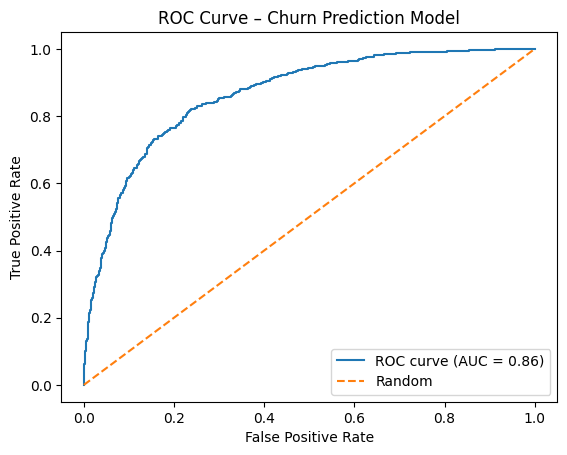

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Churn Prediction Model')
plt.legend()
plt.show()

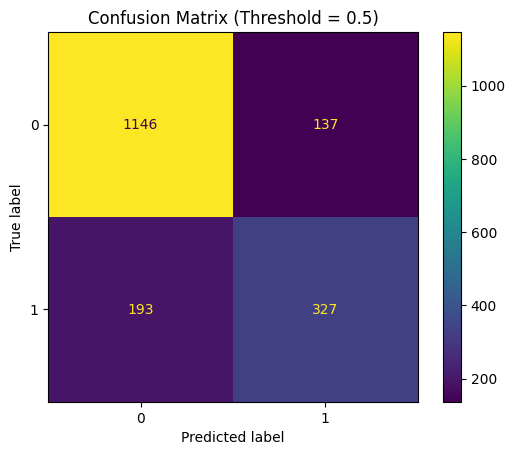

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_default = (y_prob >= 0.5).astype(int)

cm_default = confusion_matrix(y_test, y_pred_default)

disp = ConfusionMatrixDisplay(cm_default)
disp.plot()
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

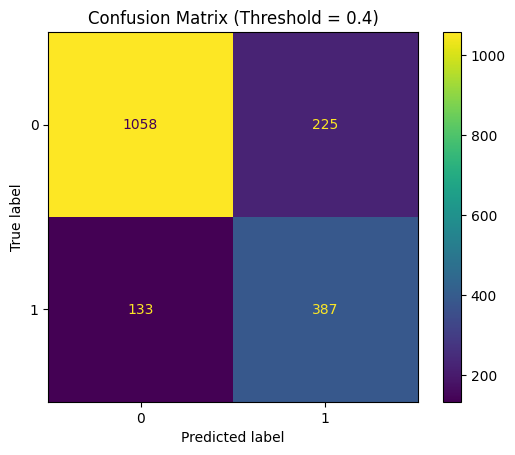

In [ ]:
threshold = 0.4
y_pred_tuned = (y_prob >= threshold).astype(int)

cm_tuned = confusion_matrix(y_test, y_pred_tuned)

disp = ConfusionMatrixDisplay(cm_tuned)
disp.plot()
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Threshold = 0.5")
print(classification_report(y_test, y_pred_default))

print("\nThreshold = 0.4")
print(classification_report(y_test, y_pred_tuned))

Threshold = 0.5
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87      1283
         1.0       0.70      0.63      0.66       520

    accuracy                           0.82      1803
   macro avg       0.78      0.76      0.77      1803
weighted avg       0.81      0.82      0.81      1803


Threshold = 0.4
              precision    recall  f1-score   support

         0.0       0.89      0.82      0.86      1283
         1.0       0.63      0.74      0.68       520

    accuracy                           0.80      1803
   macro avg       0.76      0.78      0.77      1803
weighted avg       0.81      0.80      0.81      1803



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=50, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [ ]:
from sklearn.metrics import roc_auc_score

rf_prob = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_prob)

rf_auc

np.float64(0.8837670124108159)

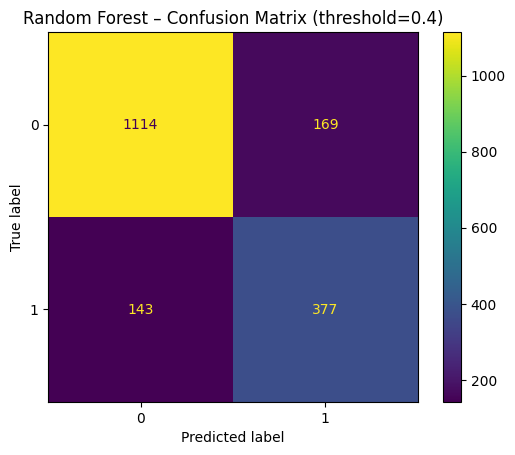

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

threshold = 0.4
rf_pred = (rf_prob >= threshold).astype(int)

cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Random Forest – Confusion Matrix (threshold={threshold})")
plt.show()

In [ ]:
import pandas as pd

rf_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

rf_importance.head(10)

,0
Total_Revenue,0.335241
Contract_Two Year,0.184971
Monthly_Charge,0.096690
Contract_One Year,0.088707
Internet_Type_Fiber Optic,0.082716
Value_Deal_Deal 5,0.071709
Age,0.049337
Payment_Method_Credit Card,0.036019
Tenure_in_Months,0.015059
Value_Deal_Deal 2,0.011591


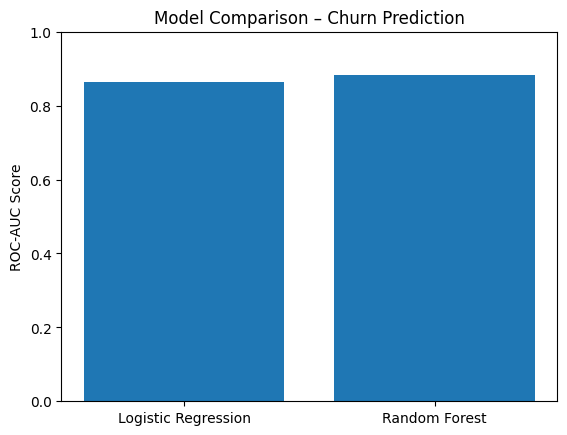

In [ ]:
import matplotlib.pyplot as plt

# AUC scores (use your computed values)
models = ['Logistic Regression', 'Random Forest']
auc_scores = [roc_auc, rf_auc]   # make sure these variables exist

plt.figure()
plt.bar(models, auc_scores)
plt.ylim(0, 1)
plt.ylabel('ROC-AUC Score')
plt.title('Model Comparison – Churn Prediction')
plt.show()

In [ ]:
print(f"Logistic Regression AUC: {roc_auc:.3f}")
print(f"Random Forest AUC: {rf_auc:.3f}")


Logistic Regression AUC: 0.865
Random Forest AUC: 0.884


In [ ]:
import numpy as np
from sklearn.metrics import recall_score

thresholds = np.arange(0.2, 0.7, 0.05)
recalls = []

for t in thresholds:
    preds = (rf_prob >= t).astype(int)
    recalls.append(recall_score(y_test, preds))

threshold_recall = dict(zip(thresholds, recalls))
threshold_recall

{np.float64(0.2): 0.8942307692307693,
 np.float64(0.25): 0.823076923076923,
 np.float64(0.3): 0.7980769230769231,
 np.float64(0.35): 0.7596153846153846,
 np.float64(0.39999999999999997): 0.725,
 np.float64(0.44999999999999996): 0.6673076923076923,
 np.float64(0.49999999999999994): 0.5788461538461539,
 np.float64(0.5499999999999999): 0.525,
 np.float64(0.5999999999999999): 0.4653846153846154,
 np.float64(0.6499999999999999): 0.38461538461538464}

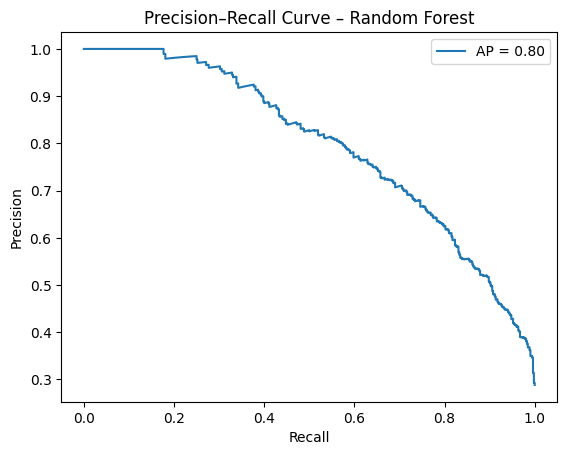

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, pr_thresholds = precision_recall_curve(y_test, rf_prob)
avg_precision = average_precision_score(y_test, rf_prob)

plt.figure()
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve – Random Forest')
plt.legend()
plt.show()

In [ ]:
best_threshold = 0.4


In [ ]:
final_preds = (rf_prob >= best_threshold).astype(int)

In [ ]:
import numpy as np
from sklearn.metrics import recall_score

thresholds = np.arange(0.2, 0.7, 0.05)
recalls = []

for t in thresholds:
    preds = (rf_prob >= t).astype(int)
    recalls.append(recall_score(y_test, preds))

best_threshold = thresholds[np.argmax(recalls)]
best_threshold

np.float64(0.2)

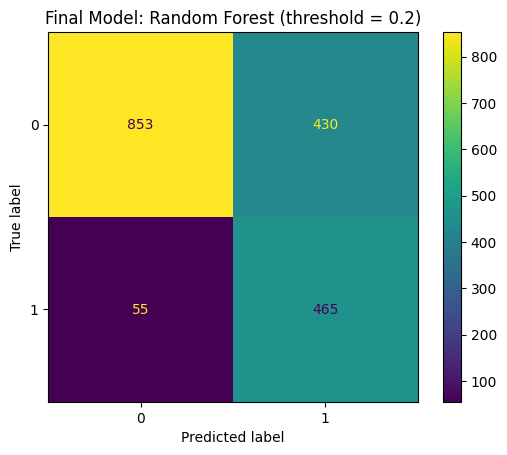

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

final_preds = (rf_prob >= best_threshold).astype(int)
cm_final = confusion_matrix(y_test, final_preds)

ConfusionMatrixDisplay(cm_final).plot()
plt.title(f"Final Model: Random Forest (threshold = {best_threshold})")
plt.show()